<a href="https://colab.research.google.com/github/gtsagkatakis/Data-Science-and-Applications/blob/main/485_Week_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Graph Neural Networks

#Graph representation

Mathematically, a graph {G} is defined as a tuple of a set of nodes/vertices V, and a set of edges/links E: {G}=(V,E). Each edge is a pair of two vertices, and represents a connection between them. For instance, let’s look at the following graph:

![](https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/06-graph-neural-networks/example_graph.svg)


The vertices are V=\{1,2,3,4\}, and edges E=\{(1,2), (2,3), (2,4), (3,4)\}. Note that for simplicity, we assume the graph to be undirected and hence don’t add mirrored pairs like (2,1). In application, vertices and edge can often have specific attributes, and edges can even be directed.

The question is how we could represent this diversity in an efficient way for matrix operations. Usually, for the edges, we decide between two variants: an adjacency matrix, or a list of paired vertex indices.

The adjacency matrix A is a square matrix whose elements indicate whether pairs of vertices are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node i to j, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that A is a symmetric matrix $(A_{ij}=A_{ji})$. For the example graph above, we have the following adjacency matrix:

$$A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}$$

While expressing a graph as a list of edges is more efficient in terms of memory and (possibly) computation, using an adjacency matrix is more intuitive and simpler to implement. Alternatively, we could also use the list of edges to define a sparse adjacency matrix with which we can work as if it was a dense matrix, but allows more memory-efficient operations.


#Graph Convolutional Networks

Graph Convolutional Networks (GCNs) are similar to convolutions in images in the sense that the “filter” parameters are typically shared over all locations in the graph. At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send “messages” to each other.

Let's try to visually understand how GCNs work.
- The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors.
- In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node.
- Finally, the messages generated by neighboring nodes are aggregated to create a new representation for each node. This aggregation operation typically involves summing, averaging, or concatenating the messages, often with learnable parameters.

Below we have visualized the two steps for our example graph.

![](https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/06-graph-neural-networks/graph_message_passing.svg)

#Implementation in Pytorch

Ιmplementing graph networks with adjacency matrix is simple and straight-forward but can be computationally expensive for large graphs. Many real-world graphs can reach over 200K nodes, for which adjacency matrix-based implementations fail. There are a lot of optimizations possible when implementing GNNs, and luckily, there exist packages that provide such layers.

PyTorch Geometric simplifies deep learning on graph data by providing efficient tools and ready-to-use modules for tasks like:
- graph/node classification,
- link prediction,
- graph generation.

It also offers benchmark datasets and includes various preprocessing tools for common graph-related tasks such as data augmentation, feature engineering, and graph transformation.

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 28.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## A Practical Example: Node Classification with Graph Neural Networks


Node-level tasks have the goal to classify nodes in a graph. Usually, we have given a single, large graph with more than 1000 nodes of which a certain amount of nodes are labeled. We learn to classify those labeled examples during training and try to generalize to the unlabeled nodes.


![](https://www.researchgate.net/publication/355873169/figure/fig1/AS:1119949498126336@1644028176568/Illustration-of-semi-supervised-node-classification-Blue-and-green-denote-those-nodes_W640.jpg)

#Load the Dataset

A popular example that we will use in this tutorial is the Cora dataset, a citation network among papers. The Cora consists of 2708 scientific publications with links between each other representing the citation of one paper by another. The task is to classify each publication into one of seven classes.

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...



Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


![](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*oygeCjtUsS87duvFoDT8tA.png)

## Let's first train a Multi-layer Perception Network (MLP)

We can infer the category of a document solely based on its feature representation using a simple MLP. The MLP model operates on input node features using shared weights across all nodes.

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


Our MLP is defined by two linear layers and enhanced by ReLU non-linearity and dropout. Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (hidden_channels=16), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP. We use the cross entropy loss and Adam optimizer. This time, we also define a test function to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9615
Epoch: 002, Loss: 1.9557
Epoch: 003, Loss: 1.9505
Epoch: 004, Loss: 1.9423
Epoch: 005, Loss: 1.9327
Epoch: 006, Loss: 1.9279
Epoch: 007, Loss: 1.9144
Epoch: 008, Loss: 1.9087
Epoch: 009, Loss: 1.9023
Epoch: 010, Loss: 1.8893
Epoch: 011, Loss: 1.8776
Epoch: 012, Loss: 1.8594
Epoch: 013, Loss: 1.8457
Epoch: 014, Loss: 1.8365
Epoch: 015, Loss: 1.8280
Epoch: 016, Loss: 1.7965
Epoch: 017, Loss: 1.7984
Epoch: 018, Loss: 1.7832
Epoch: 019, Loss: 1.7495
Epoch: 020, Loss: 1.7441
Epoch: 021, Loss: 1.7188
Epoch: 022, Loss: 1.7124
Epoch: 023, Loss: 1.6785
Epoch: 024, Loss: 1.6660
Epoch: 025, Loss: 1.6119
Epoch: 026, Loss: 1.6236
Epoch: 027, Loss: 1.5827
Epoch: 028, Loss: 1.5784
Epoch: 029, Loss: 1.5524
Epoch: 030, Loss: 1.5020
Epoch: 031, Loss: 1.5065
Epoch: 032, Loss: 1.4742
Epoch: 033, Loss: 1.4581
Epoch: 034, Loss: 1.4246
Epoch: 035, Loss: 1.4131
Epoch: 036, Loss: 1.4112
Epoch: 037, Loss: 1.3923
Epoch: 038, Loss: 1.3055
Epoch: 039, Loss: 1.2982
Epoch: 040, Loss: 1.2543


After training the model, we can call the test function to see how well our model performs on unseen labels. Here, we are interested in the accuracy of the model, i.e., the ratio of correctly classified nodes:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5900


As one can see, our MLP performs rather bad with only about 59% test accuracy.

**But why does the MLP do not perform better?**

The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



# Training a Graph Convolutional Neural Network (GCN)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


# Define the training and validation functions for the GCN model

In [ ]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


#Train the model

In [ ]:
for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


# Predict on the test set

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


# Graph Classification with GCN

The most common task for graph classification is **molecular property prediction**, in which molecules are represented as graphs, and the task may be to infer whether a molecule inhibits HIV virus replication or not.

The TU Dortmund University has collected a wide range of different graph classification datasets, known as the [**TUDatasets**](https://chrsmrrs.github.io/datasets/), which are also accessible via [`torch_geometric.datasets.TUDataset`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.TUDataset) in PyTorch Geometric.
Let's load and inspect one of the smaller ones, the **MUTAG dataset**.

![](https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/06-graph-neural-networks/molecule_graph.svg)

In [ ]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Processing...
Done!


# Graph visualization

In [ ]:
pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.1 MB/s eta 0:00:00


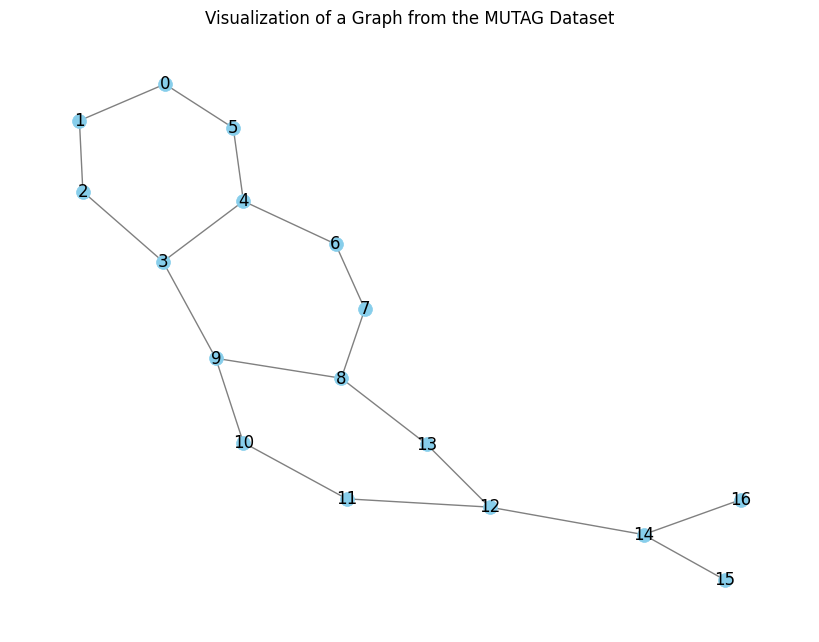

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert the PyG Data object to a NetworkX graph
G = nx.Graph()
G.add_nodes_from(range(data.num_nodes))
edge_index = data.edge_index.t().tolist()
G.add_edges_from(edge_index)

# Visualize the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=100, edge_color='gray', linewidths=0.5)
plt.title('Visualization of a Graph from the MUTAG Dataset')
plt.show()


This dataset provides **188 different graphs**, and the task is to classify each graph into **one out of two classes**.

By inspecting the first graph object of the dataset, we can see that it comes with **17 nodes (with 7-dimensional feature vectors)** and **38 edges** (leading to an average node degree of 2.24).
It also comes with exactly **one graph label** (`y=[1]`), and, in addition to previous datasets, provides addtional **4-dimensional edge features** (`edge_attr=[38, 4]`).
However, for the sake of simplicity, we will not make use of those.

PyTorch Geometric provides some useful utilities for working with graph datasets, *e.g.*, we can shuffle the dataset and use the first 150 graphs as training graphs, while using the remaining ones for testing:

In [ ]:
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


## Mini-batching of graphs

Since graphs in graph classification datasets are usually small, a good idea is to **batch the graphs** before inputting them into a Graph Neural Network to guarantee full GPU utilization.
In the image or language domain, this procedure is typically achieved by **rescaling** or **padding** each example into a set of equally-sized shapes, and examples are then grouped in an additional dimension.
The length of this dimension is then equal to the number of examples grouped in a mini-batch and is typically referred to as the `batch_size`.

However, for GNNs the two approaches described above are either not feasible or may result in a lot of unnecessary memory consumption.
Therefore, PyTorch Geometric opts for another approach to achieve parallelization across a number of examples. Here, adjacency matrices are stacked in a diagonal fashion (creating a giant graph that holds multiple isolated subgraphs), and node and target features are simply concatenated in the node dimension.

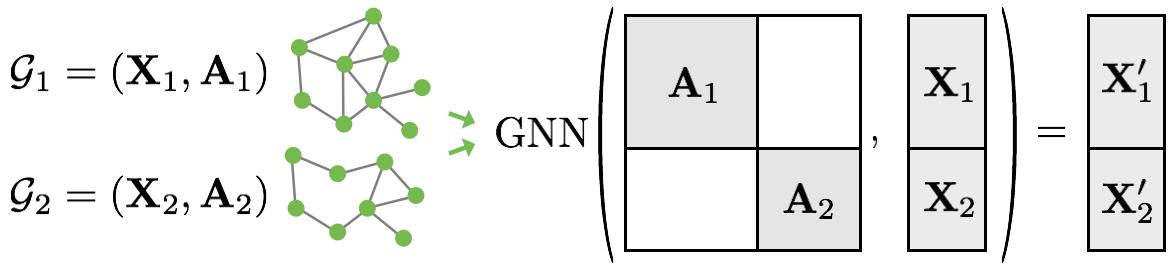

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



## Training the GCN

Training a GCN for graph classification usually follows a simple recipe:

1. Embed each node by performing multiple rounds of message passing
2. Aggregate node embeddings into a unified graph embedding (**readout layer**)
3. Train a final classifier on the graph embedding

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


Let's train our network for a few epochs to see how well it performs on the training as well as test set.

In [ ]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

Epoch: 001, Train Acc: 0.6467
Epoch: 002, Train Acc: 0.6467
Epoch: 003, Train Acc: 0.6467
Epoch: 004, Train Acc: 0.6467
Epoch: 005, Train Acc: 0.6467
Epoch: 006, Train Acc: 0.6867
Epoch: 007, Train Acc: 0.7133
Epoch: 008, Train Acc: 0.7467
Epoch: 009, Train Acc: 0.7133
Epoch: 010, Train Acc: 0.7200
Epoch: 011, Train Acc: 0.7267
Epoch: 012, Train Acc: 0.7067
Epoch: 013, Train Acc: 0.7200
Epoch: 014, Train Acc: 0.7333
Epoch: 015, Train Acc: 0.7200
Epoch: 016, Train Acc: 0.7133
Epoch: 017, Train Acc: 0.7333
Epoch: 018, Train Acc: 0.7600
Epoch: 019, Train Acc: 0.7200
Epoch: 020, Train Acc: 0.7267
Epoch: 021, Train Acc: 0.7533
Epoch: 022, Train Acc: 0.7533
Epoch: 023, Train Acc: 0.7267
Epoch: 024, Train Acc: 0.7400
Epoch: 025, Train Acc: 0.7533
Epoch: 026, Train Acc: 0.7533
Epoch: 027, Train Acc: 0.7400
Epoch: 028, Train Acc: 0.7333
Epoch: 029, Train Acc: 0.7467
Epoch: 030, Train Acc: 0.7467
Epoch: 031, Train Acc: 0.7600
Epoch: 032, Train Acc: 0.7667
Epoch: 033, Train Acc: 0.7600
Epoch: 034

In [ ]:
test_acc = test(test_loader)
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.7895


# HOMEWORK 5

Perform node classification on the PubMed dataset to classify scientific publications into their respective categories. The PubMed dataset is a citation network among scientific publications. It consists of articles related to diabetes, with each article belonging to one of three categories: "Diabetes Mellitus Type 1" (class 0), "Diabetes Mellitus Type 2" (class 1), and "Diabetes Mellitus" (class 2).

# Install required packages.


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.2.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Load the dataset

In [ ]:
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='data/Planetoid', name='PubMed')

# Print dataset information
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)

Processing...



Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


Done!


# Define a GCN network


# Visualize the node embeddings of the untrained GCN network using PCA

#Perform a grid search hyperparameter tuning for the following parameters
- Number of Layers
- Hidden Dimension Size
- Learning Rate
- Dropout Rate
- Batch Size

 # Train the GCN model with the optimal hyperparameters and select the best model based on the highest validation performance

# Visualize the output embeddings of your trained model. What do you observe?

#Evaluate the trained model on the test set and report the classification accuracy